In [1]:
import sys
import numpy as np
import torch
from datasets.dataset_multitask_1d import motask_generator
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
figsiz_=(11,2.5*2)
fontsiz = 18


plt.rc('figure', figsize=figsiz_,dpi=100)
plt.rcParams['figure.figsize'] = figsiz_
plt.rc('font', family='serif', size=fontsiz)

In [3]:
import time 
import random
random_seed = 1111
torch.manual_seed(random_seed)
random.seed(random_seed)
np.random.seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
# # from test_baseline import Convcnp,compute_loss_baseline
# # from test_baseline_latent import  Convcnp_latent, compute_loss_baselinelatent
# # #from test_correlatenp import  CGP_Convnp,compute_loss_gp        
# # from test_mocorrelatenp import  CGP_Convnp,compute_loss_gp        
# import sys
# sys.path.append('./../')

from models.test_baseline import Convcnp,compute_loss_baseline
from models.test_baseline_latent import  Convcnp_latent, compute_loss_baselinelatent
from models.test_ind_correlatenp import  ICGP_Convnp,compute_loss_gp  
from models.test_dep_correlatenp import  DCGP_Convnp,compute_loss_gp  
from models.test_cnp import RegressionANP, RegressionCNP
from torch.distributions.normal import Normal

num_nchannels= 1
nsamples_latent=10
nsamples_gp=10

lr = 0.001
weight_decay=1e-4
def get_model(modelname='gp',cnntype='deep'):        
    
    if modelname == 'base':
        model = Convcnp(in_dims=1,out_dims=1,num_channels=num_nchannels,cnntype=cnntype).cuda()
        opt = torch.optim.Adam(model.parameters(), lr=lr,weight_decay = weight_decay)
        lossfun = compute_loss_baseline

    if modelname == 'baselatent':
        model = Convcnp_latent(in_dims=1,out_dims=1,num_channels=num_nchannels,num_postsamples=nsamples_latent,cnntype=cnntype).cuda()
        opt = torch.optim.Adam(model.parameters(), lr=lr,weight_decay = weight_decay)
        lossfun = compute_loss_baselinelatent
        
    if modelname == 'gpind':        
        model = ICGP_Convnp(in_dims=1,out_dims=1,num_channels=num_nchannels,num_postsamples=nsamples_gp,cnntype=cnntype).cuda()
        opt = torch.optim.Adam(model.parameters(), lr=lr,weight_decay = weight_decay)
        lossfun = compute_loss_gp
        
        
    if modelname == 'gpdep':        
        model = DCGP_Convnp(in_dims=1,out_dims=1,num_channels=num_nchannels,num_postsamples=nsamples_gp,cnntype=cnntype).cuda()
        opt = torch.optim.Adam(model.parameters(), lr=lr,weight_decay = weight_decay)
        lossfun = compute_loss_gp
        
                
      
    return model,opt,lossfun





proposed_model_list = ['gpind','gpdep']
def validate_epochs_pair(batch_dataset_pair,model,lossfun):
    # large is better 
    
    model.eval()
    
    likelihoods = []
    likelihoods2 = []    
    ntask = len(batch_dataset_pair)
    for dataset_pair in batch_dataset_pair:
        
#        try:        
        context_x,context_y,target_x,target_y,full_x,full_y = dataset_pair        
        if model.modelname in proposed_model_list and len(context_x.size()) == 3:                
            context_x,target_x=context_x.unsqueeze(dim=-2),target_x.unsqueeze(dim=-2)


        outs = model(context_x.cuda(),context_y.cuda(),target_x.cuda())                        
        obj = -lossfun( outs.pymu, outs.pystd, target_y.cuda(), intrain=False, reduce=False)        
            
        likelihoods += list(obj.cpu().data.numpy())        

        
    
    
    likelihoods=np.array(likelihoods)                
    num_nanlikelihoods = np.count_nonzero(~np.isnan(likelihoods))
    avg_ll,std_ll = np.nanmean(likelihoods).round(2), (np.nanstd(likelihoods)/np.sqrt(num_nanlikelihoods+1e-8)).round(2)    
    
    num_nanlikelihoods2 = np.count_nonzero(~np.isnan(likelihoods2))    
    avg_ll2,std_ll2 = np.nanmean(likelihoods2).round(2), (np.nanstd(likelihoods2)/np.sqrt(num_nanlikelihoods2+1e-8)).round(2)    
    
    return avg_ll,std_ll,avg_ll2,std_ll2      

    


    

## loads dataset and checks

In [5]:
#pstd_xt
import matplotlib.pyplot as plt

figsiz_=(20,2)
color_list = ['r','b','g']
predicted_model_list = ['gpind','gpdep','baselatent']

## Take models and load params

## load params

In [6]:
testtype = 'extra'
dep = True
tasktype = 'singletask'
bestparam_path = './params/param_{}/'.format(tasktype)
bestparam_path

'./params/param_singletask/'

## load saved model params

In [7]:
import glob
def filter_savefilename(bestparam_path, depoption=True,modelname=[],datav=['datav4'],runv=['runv25']):
    
    saved_modelparam_path_list = glob.glob(bestparam_path +'*.pth'.format(tasktype))
    saved_modelparam_path_list.sort()
    saved_modelparam_path_list
    
    outs = []
    for ith in saved_modelparam_path_list:
        spec = ith.split('/')[-1].split('_')
        condi1 = spec[7] in datav and datav is not None
        condi2 = spec[9] in runv and runv is not None
        if len(modelname) == 0:
            condi3 = True
        else:
            condi3 = spec[2] in modelname             
        condi4 = spec[0] == 'dep'+str(depoption)
            
        if condi1 and condi2 and condi3 and condi4:                                                         
            outs.append(ith)
    #print(outs)
    return outs

## Check prediction results for small context set (datav = 1) 

In [8]:
import torch.nn.functional as F
from  models.test_gpsampler7 import eval_smkernel_batch


In [9]:
datav = 1

# load dataset

In [10]:
#saved_dataset_list
#saved_dataset_list = glob.glob('./syndata_{}_v{}_test/dep{}*.db'.format(tasktype,datav,dep))
saved_dataset_list = glob.glob('./download/syndata_{}/dep{}*.db'.format(tasktype,dep))

testset_dict = torch.load(saved_dataset_list[0])
print('-'*100)
print('dataset loaded')
print('loaded file : {}'.format(saved_dataset_list[0]))
print('-'*100)





----------------------------------------------------------------------------------------------------
dataset loaded
loaded file : ./download/syndata_singletask/depTrue_extra_nvaltask32.db
----------------------------------------------------------------------------------------------------


# load modelparams for task-depednet prior model (gpdep)

In [11]:

modelparam_path = filter_savefilename(bestparam_path,depoption=dep,modelname=['gpdep'],datav=['datav{}'.format(datav)],runv=['runv1'])[0] #shallow network

print('-'*100)
print('saved param loaded')
#print('loaded file : {}'.format(saved_dataset_list[0]))
print(modelparam_path)
print('-'*100)


----------------------------------------------------------------------------------------------------
saved param loaded
./params/param_singletask/depTrue_extra_gpdep_initl1.0_deep_nsamples10_nepochs500_datav1_gppriorscale1.0_runv1_reglam0.0.pth
----------------------------------------------------------------------------------------------------


In [12]:

nch=0
fontsiz_=13
figsiz_=(8.0,1.8)
alpha_=0.2
eps=0.5
ylim_ = [-1-eps,1+eps]
delta=0.1

ylimlist_ = [[-2-delta,2+delta],[-2-delta,2+delta],[-2-delta,3+delta],[0-delta,1.1+delta]]


# Inside training range 

current task: rbf
spikeslab version 7 with tempering 0.1
----------------------------------------------------------------------------------------------------
current task idx 4
----------------------------------------------------------------------------------------------------
xc.shape torch.Size([16, 19, 1]), yc.shape torch.Size([16, 19, 1]), xt.shapetorch.Size([16, 250, 1]), yt.shapetorch.Size([16, 250, 1])


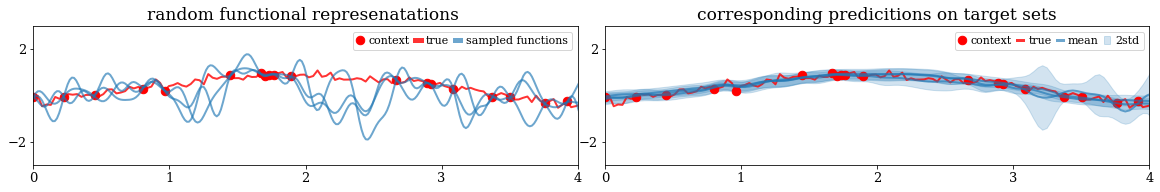

----------------------------------------------------------------------------------------------------
current task idx 8
----------------------------------------------------------------------------------------------------
xc.shape torch.Size([16, 19, 1]), yc.shape torch.Size([16, 19, 1]), xt.shapetorch.Size([16, 250, 1]), yt.shapetorch.Size([16, 250, 1])


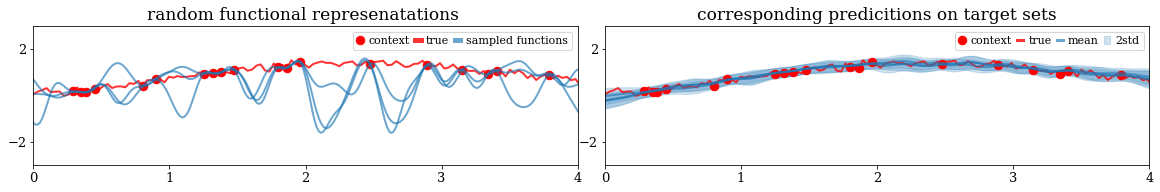






current task: matern
spikeslab version 7 with tempering 0.1
----------------------------------------------------------------------------------------------------
current task idx 4
----------------------------------------------------------------------------------------------------
xc.shape torch.Size([16, 6, 1]), yc.shape torch.Size([16, 6, 1]), xt.shapetorch.Size([16, 250, 1]), yt.shapetorch.Size([16, 250, 1])


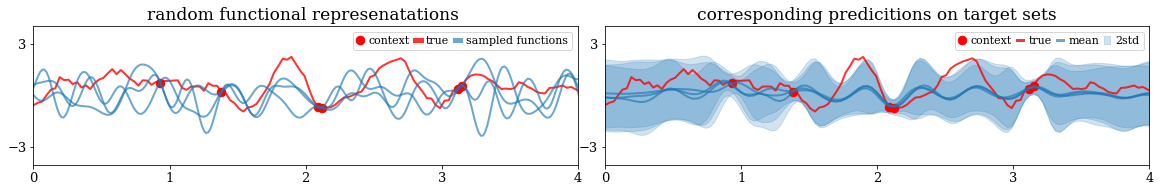

----------------------------------------------------------------------------------------------------
current task idx 8
----------------------------------------------------------------------------------------------------
xc.shape torch.Size([16, 6, 1]), yc.shape torch.Size([16, 6, 1]), xt.shapetorch.Size([16, 250, 1]), yt.shapetorch.Size([16, 250, 1])


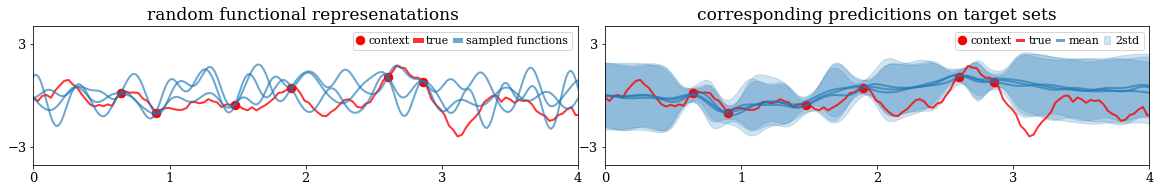






current task: weaklyperiodic
spikeslab version 7 with tempering 0.1
----------------------------------------------------------------------------------------------------
current task idx 4
----------------------------------------------------------------------------------------------------
xc.shape torch.Size([16, 22, 1]), yc.shape torch.Size([16, 22, 1]), xt.shapetorch.Size([16, 250, 1]), yt.shapetorch.Size([16, 250, 1])


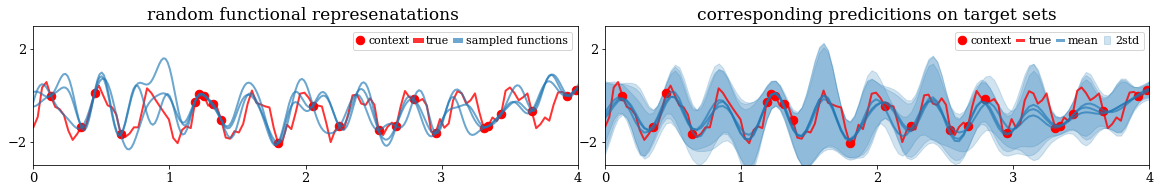

----------------------------------------------------------------------------------------------------
current task idx 8
----------------------------------------------------------------------------------------------------
xc.shape torch.Size([16, 22, 1]), yc.shape torch.Size([16, 22, 1]), xt.shapetorch.Size([16, 250, 1]), yt.shapetorch.Size([16, 250, 1])


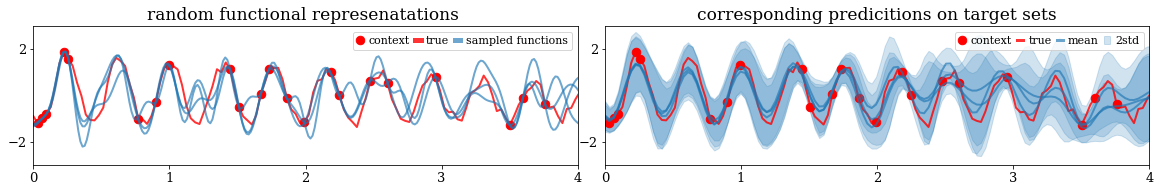






current task: sawtooth
spikeslab version 7 with tempering 0.1
----------------------------------------------------------------------------------------------------
current task idx 4
----------------------------------------------------------------------------------------------------
xc.shape torch.Size([16, 11, 1]), yc.shape torch.Size([16, 11, 1]), xt.shapetorch.Size([16, 250, 1]), yt.shapetorch.Size([16, 250, 1])


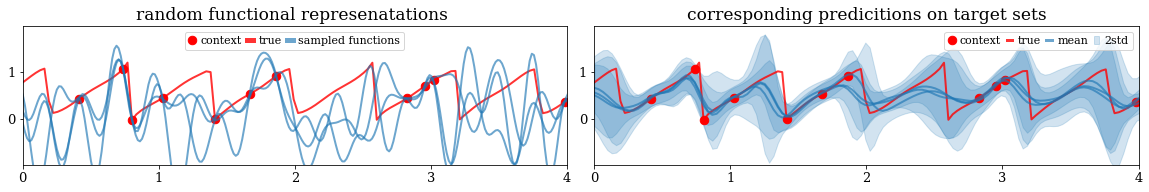

----------------------------------------------------------------------------------------------------
current task idx 8
----------------------------------------------------------------------------------------------------
xc.shape torch.Size([16, 11, 1]), yc.shape torch.Size([16, 11, 1]), xt.shapetorch.Size([16, 250, 1]), yt.shapetorch.Size([16, 250, 1])


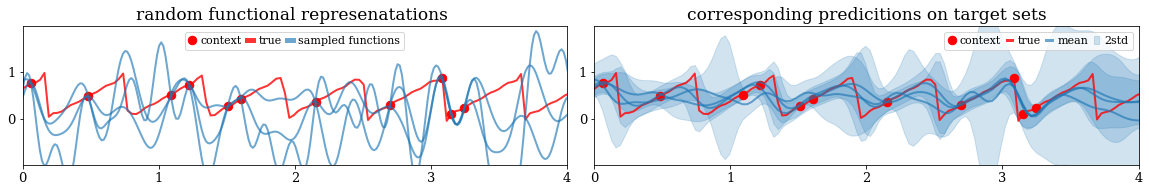

In [13]:
import torch.nn.functional as F
from  models.test_gpsampler7 import eval_smkernel_batch

fontsiz_=13
#figsiz_=(8.0,1.8)
figsiz_=(20.0,2.55)

alpha_=0.2
eps=0.5
ylim_ = [-1-eps,1+eps]


chosenidx=0 # choss epochs number [0,31]
inrangetask = True
xlim_ = [0,4]
xticks_=np.linspace(xlim_[0],xlim_[1],5)





task_list = [4,8]
#task_list = np.sort(np.random.randint(0,16,2))

for ith,ith_key in enumerate(testset_dict):
    ith_taskset = testset_dict[ith_key]    
    
    if inrangetask:
        xc,yc,xt,yt,xf,yf = ith_taskset['train_set'][chosenidx] #inrage
    else:
        xc,yc,xt,yt,xf,yf = ith_taskset['valid_set'][chosenidx] #inrage
        
    #-----------------------------------------
    #prediction
    #-----------------------------------------
    print('current task: {}'.format(ith_key))
            
    #modelname='gpdep'
    #cnntype='deep'

    _,_,param_saved,param_detail = modelparam_path.split('/')        
    tasktype = param_saved.split('_')[1]
    deptype = param_detail.split('_')[0]
    modelname = param_detail.split('_')[2]
    cnntype = param_detail.split('_')[4]
    runv = param_detail.split('_')[9
                                  ]    
    model,opt,lossfun =  get_model(modelname=modelname,cnntype=cnntype)
    saved_dict = torch.load(modelparam_path)
    
    model.load_state_dict(saved_dict['state_dict'])                
    spec = modelname + cnntype + runv
    xstar,ystar = xf,yf  
    
    
    #model.train()    
    model.eval()
    if model.modelname in proposed_model_list:
        tmp_numsamples=3
        model.num_samples = tmp_numsamples                     
        outs = model(xc[:,:,None,:].cuda(),yc.cuda(),xstar[:,:,None,:].cuda())  
        
    else:
        outs = model(xc.cuda(),yc.cuda(),xstar.cuda())       
    pmu_xt,pstd_xt = outs.pymu,outs.pystd


    #-----------------------------------------
    #figures
    #-----------------------------------------
    #------------------        
    #nbidx=7
    #------------------        
    for nbidx in task_list:
        print('-'*100)
        print('current task idx {}'.format(nbidx))
        print('-'*100)

        fontsiz_=13    
        #print(param_detail)
        #print(param_detail)
        fig = plt.figure(figsize=figsiz_)   
        plt.subplots_adjust(wspace=0.05)


        #------------------------------------------------------------------------------------
        # construcut functional representaions
        #------------------------------------------------------------------------------------    
        plt.subplot(1,2,1)        
        print('xc.shape {}, yc.shape {}, xt.shape{}, yt.shape{}'.format(xc.shape,yc.shape,xstar.shape,ystar.shape))
        post_samples=outs.gpouts.posterior_samples
        xa=outs.gpouts.xa_samples        
        plt.plot(xc[nbidx,:,0],yc[nbidx,:,0],'r'+'o',markersize=8.5,label='context')    
        plt.plot(xstar[nbidx,:,0],ystar[nbidx,:,0],'r'+'-',markersize=2,alpha=0.8,linewidth=2.,label = 'true')


        for j in range(tmp_numsamples):    
            if j ==0:
                plt.plot(xa[nbidx,0,:,0].cpu().data.numpy(),
                         post_samples[nbidx,j,:,nch].cpu().data.numpy(),
                         color='tab:blue',
                         linewidth=2,
                         alpha=0.65,
                         label = 'sampled functions')          
            else:
                plt.plot(xa[nbidx,0,:,0].cpu().data.numpy(),
                         post_samples[nbidx,j,:,nch].cpu().data.numpy(),
                         color='tab:blue',
                         linewidth=2,
                         alpha=0.65)          


        plt.xlim(xlim_)
        ylim_ = [int(yf.min().item()-1.),int(yf.max().item()+1.)]
        plt.ylim(ylim_)
        #plt.xticks(fontsize=fontsiz_)
        plt.xticks(xticks_,fontsize=fontsiz_)    
        plt.yticks([ylim_[0]+1,ylim_[1]-1],fontsize=fontsiz_)
        #plt.yticks([-1,1],fontsize=fontsiz_)
        plt.title('random functional represenatations ',fontsize=17)

        leg=plt.legend(loc='best',fontsize=11,ncol=4,columnspacing=0.5,handlelength=0.5,handletextpad=.5)    
        for line in leg.get_lines():
            line.set_linewidth(5) 
            line.set_markersize(5)     







        #------------------------------------------------------------------------------------
        # prediction    
        #------------------------------------------------------------------------------------
        plt.subplot(1,2,2)
        plt.plot(xc[nbidx,:,0],yc[nbidx,:,0],'r'+'o',markersize=8.5,label='context')
        plt.plot(xstar[nbidx,:,0],ystar[nbidx,:,0],'r'+'-',markersize=2,alpha=0.8,linewidth=2.,label = 'true')

        #tmp_num_samples=3
        for j in range(tmp_numsamples):    
            mean=pmu_xt[j,nbidx,:,nch].cpu().data.numpy()
            ub=(pmu_xt+2*pstd_xt)[j,nbidx,:,nch].cpu().data.numpy()
            lb=(pmu_xt-2*pstd_xt)[j,nbidx,:,nch].cpu().data.numpy()                

            if j ==0:
                plt.plot(xstar[nbidx,:,0].cpu().data.numpy(),
                         mean,
                         color='tab:blue',
                         linewidth=2,
                         alpha=0.65,
                         label='mean') #,label = 'Model' ,alpha=2.5*alpha_

                plt.fill_between(xstar[nbidx,:,0].cpu().data.numpy(),
                                 ub,
                                 lb,
                                 color='tab:blue',
                                 alpha=alpha_,
                                 label='2std')        

            else:
                plt.plot(xstar[nbidx,:,0].cpu().data.numpy(),
                         mean,
                         color='tab:blue',
                         linewidth=2,
                         alpha=0.65) #,label = 'Model' ,alpha=2.5*alpha_

                plt.fill_between(xstar[nbidx,:,0].cpu().data.numpy(),
                                 ub,
                                 lb,
                                 color='tab:blue',
                                 alpha=alpha_)        


        plt.xlim(xlim_)
        ylim_ = [int(yf.min().item()-1.),int(yf.max().item()+1.)]
        plt.ylim(ylim_)
        #plt.xticks(fontsize=fontsiz_)
        plt.xticks(xticks_,fontsize=fontsiz_)    
        plt.yticks([ylim_[0]+1,ylim_[1]-1],fontsize=fontsiz_)
        plt.title('corresponding predicitions on target sets',fontsize=17)

        #if ith_key == 'matern':
        leg=plt.legend(loc='best',fontsize=11,ncol=4,columnspacing=0.5,handlelength=0.5,handletextpad=.5)        
        for line in leg.get_lines():
            line.set_linewidth(3) 
            line.set_markersize(3)  

        plt.show()
    print('\n'*4)
    
    
    

# outside training range

current task: rbf
spikeslab version 7 with tempering 0.1
----------------------------------------------------------------------------------------------------
current task idx 4
----------------------------------------------------------------------------------------------------
xc.shape torch.Size([16, 19, 1]), yc.shape torch.Size([16, 19, 1]), xt.shapetorch.Size([16, 250, 1]), yt.shapetorch.Size([16, 250, 1])


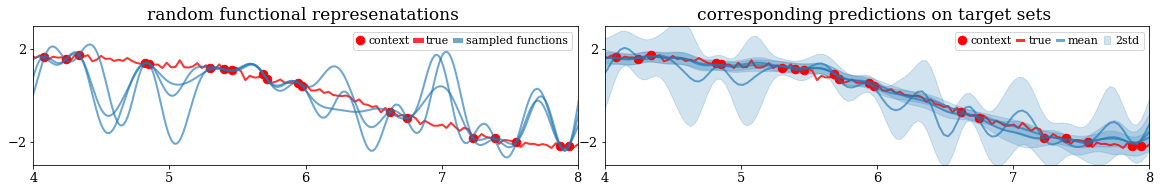

----------------------------------------------------------------------------------------------------
current task idx 8
----------------------------------------------------------------------------------------------------
xc.shape torch.Size([16, 19, 1]), yc.shape torch.Size([16, 19, 1]), xt.shapetorch.Size([16, 250, 1]), yt.shapetorch.Size([16, 250, 1])


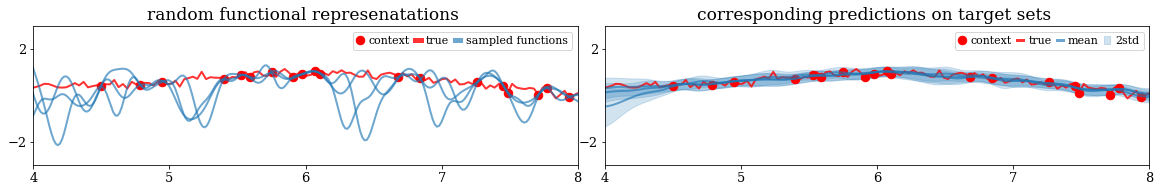






current task: matern
spikeslab version 7 with tempering 0.1
----------------------------------------------------------------------------------------------------
current task idx 4
----------------------------------------------------------------------------------------------------
xc.shape torch.Size([16, 6, 1]), yc.shape torch.Size([16, 6, 1]), xt.shapetorch.Size([16, 250, 1]), yt.shapetorch.Size([16, 250, 1])


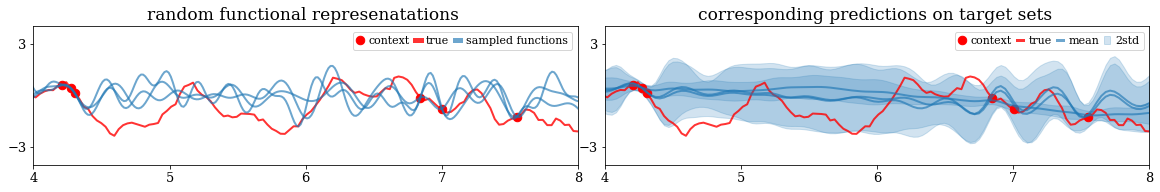

----------------------------------------------------------------------------------------------------
current task idx 8
----------------------------------------------------------------------------------------------------
xc.shape torch.Size([16, 6, 1]), yc.shape torch.Size([16, 6, 1]), xt.shapetorch.Size([16, 250, 1]), yt.shapetorch.Size([16, 250, 1])


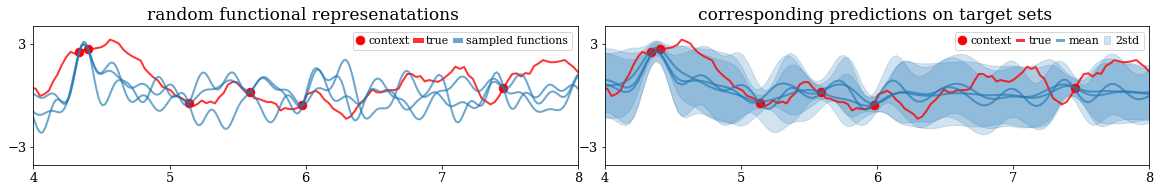






current task: weaklyperiodic
spikeslab version 7 with tempering 0.1
----------------------------------------------------------------------------------------------------
current task idx 4
----------------------------------------------------------------------------------------------------
xc.shape torch.Size([16, 22, 1]), yc.shape torch.Size([16, 22, 1]), xt.shapetorch.Size([16, 250, 1]), yt.shapetorch.Size([16, 250, 1])


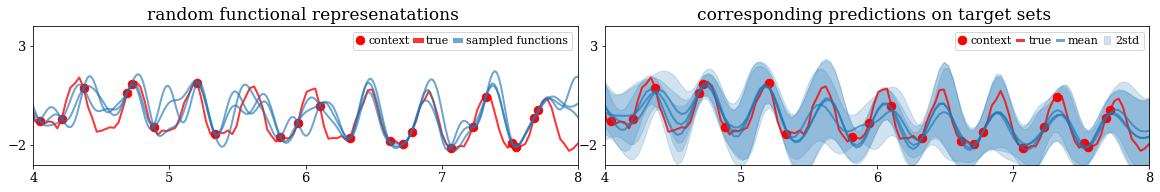

----------------------------------------------------------------------------------------------------
current task idx 8
----------------------------------------------------------------------------------------------------
xc.shape torch.Size([16, 22, 1]), yc.shape torch.Size([16, 22, 1]), xt.shapetorch.Size([16, 250, 1]), yt.shapetorch.Size([16, 250, 1])


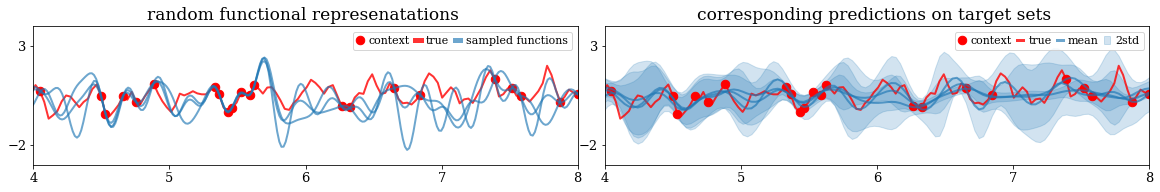






current task: sawtooth
spikeslab version 7 with tempering 0.1
----------------------------------------------------------------------------------------------------
current task idx 4
----------------------------------------------------------------------------------------------------
xc.shape torch.Size([16, 11, 1]), yc.shape torch.Size([16, 11, 1]), xt.shapetorch.Size([16, 250, 1]), yt.shapetorch.Size([16, 250, 1])


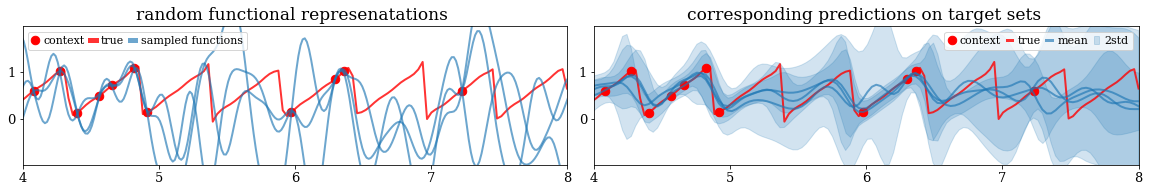

----------------------------------------------------------------------------------------------------
current task idx 8
----------------------------------------------------------------------------------------------------
xc.shape torch.Size([16, 11, 1]), yc.shape torch.Size([16, 11, 1]), xt.shapetorch.Size([16, 250, 1]), yt.shapetorch.Size([16, 250, 1])


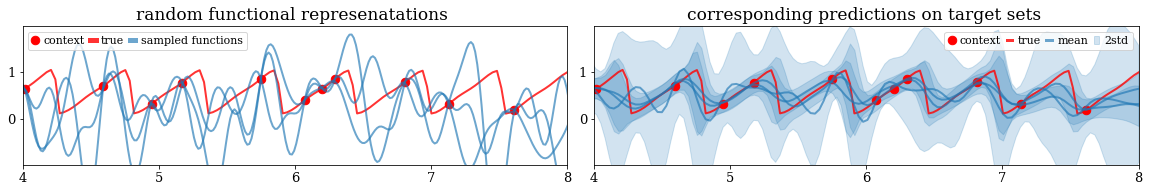

In [14]:
import torch.nn.functional as F
from  models.test_gpsampler7 import eval_smkernel_batch


#chosenidx=0
inrangetask = False
xlim_ = [4,8]
xticks_=np.linspace(xlim_[0],xlim_[1],5)




for ith,ith_key in enumerate(testset_dict):
    ith_taskset = testset_dict[ith_key]    
    #testset_inrange = ith_taskset['train_set'][nbidx]
    #testset_outrange = ith_taskset['valid_set']    
    
    if inrangetask:
        xc,yc,xt,yt,xf,yf = ith_taskset['train_set'][chosenidx] #inrage
    else:
        xc,yc,xt,yt,xf,yf = ith_taskset['valid_set'][chosenidx] #inrage
        
    print('current task: {}'.format(ith_key))
        
    #-----------------------------------------
    #prediction
    #-----------------------------------------
    _,_,param_saved,param_detail = modelparam_path.split('/')        
    tasktype = param_saved.split('_')[1]
    deptype = param_detail.split('_')[0]
    modelname = param_detail.split('_')[2]
    cnntype = param_detail.split('_')[4]
    runv = param_detail.split('_')[9
                                  ]    
    model,opt,lossfun =  get_model(modelname=modelname,cnntype=cnntype)
    saved_dict = torch.load(modelparam_path)
    model.load_state_dict(saved_dict['state_dict'])                
    spec = modelname + cnntype + runv
    xstar,ystar = xf,yf  
    
    
    #model.train()    
    model.eval()
    if model.modelname in proposed_model_list:
        tmp_numsamples=3
        model.num_samples = tmp_numsamples                     
        outs = model(xc[:,:,None,:].cuda(),yc.cuda(),xstar[:,:,None,:].cuda())  
        
    else:
        outs = model(xc.cuda(),yc.cuda(),xstar.cuda())       
    pmu_xt,pstd_xt = outs.pymu,outs.pystd


    #-----------------------------------------
    #figures
    #-----------------------------------------
    #------------------        
    #nbidx=7
    #------------------        
    for nbidx in task_list:
        print('-'*100)
        print('current task idx {}'.format(nbidx))
        print('-'*100)

        fontsiz_=13    
        #print(param_detail)
        #print(param_detail)
        fig = plt.figure(figsize=figsiz_)   
        plt.subplots_adjust(wspace=0.05)


        #------------------------------------------------------------------------------------
        # construcut functional representaions
        #------------------------------------------------------------------------------------    
        plt.subplot(1,2,1)        
        print('xc.shape {}, yc.shape {}, xt.shape{}, yt.shape{}'.format(xc.shape,yc.shape,xstar.shape,ystar.shape))
        post_samples=outs.gpouts.posterior_samples
        xa=outs.gpouts.xa_samples        
        plt.plot(xc[nbidx,:,0],yc[nbidx,:,0],'r'+'o',markersize=8.5,label='context')    
        plt.plot(xstar[nbidx,:,0],ystar[nbidx,:,0],'r'+'-',markersize=2,alpha=0.8,linewidth=2.,label = 'true')


        for j in range(tmp_numsamples):    
            if j ==0:
                plt.plot(xa[nbidx,0,:,0].cpu().data.numpy(),
                         post_samples[nbidx,j,:,nch].cpu().data.numpy(),
                         color='tab:blue',
                         linewidth=2,
                         alpha=0.65,
                         label = 'sampled functions')          
            else:
                plt.plot(xa[nbidx,0,:,0].cpu().data.numpy(),
                         post_samples[nbidx,j,:,nch].cpu().data.numpy(),
                         color='tab:blue',
                         linewidth=2,
                         alpha=0.65)          


        plt.xlim(xlim_)
        ylim_ = [int(yf.min().item()-1.),int(yf.max().item()+1.)]
        plt.ylim(ylim_)
        #plt.xticks(fontsize=fontsiz_)
        plt.xticks(xticks_,fontsize=fontsiz_)    
        plt.yticks([ylim_[0]+1,ylim_[1]-1],fontsize=fontsiz_)
        #plt.yticks([-1,1],fontsize=fontsiz_)
        plt.title('random functional represenatations ',fontsize=17)
        

        leg=plt.legend(loc='best',fontsize=11,ncol=4,columnspacing=0.5,handlelength=0.5,handletextpad=.5)    
        for line in leg.get_lines():
            line.set_linewidth(5) 
            line.set_markersize(5)     







        #------------------------------------------------------------------------------------
        # prediction    
        #------------------------------------------------------------------------------------
        plt.subplot(1,2,2)
        plt.plot(xc[nbidx,:,0],yc[nbidx,:,0],'r'+'o',markersize=8.5,label='context')
        plt.plot(xstar[nbidx,:,0],ystar[nbidx,:,0],'r'+'-',markersize=2,alpha=0.8,linewidth=2.,label = 'true')

        #tmp_num_samples=3
        for j in range(tmp_numsamples):    
            mean=pmu_xt[j,nbidx,:,nch].cpu().data.numpy()
            ub=(pmu_xt+2*pstd_xt)[j,nbidx,:,nch].cpu().data.numpy()
            lb=(pmu_xt-2*pstd_xt)[j,nbidx,:,nch].cpu().data.numpy()                

            if j ==0:
                plt.plot(xstar[nbidx,:,0].cpu().data.numpy(),
                         mean,
                         color='tab:blue',
                         linewidth=2,
                         alpha=0.65,
                         label='mean') #,label = 'Model' ,alpha=2.5*alpha_

                plt.fill_between(xstar[nbidx,:,0].cpu().data.numpy(),
                                 ub,
                                 lb,
                                 color='tab:blue',
                                 alpha=alpha_,
                                 label='2std')        

            else:
                plt.plot(xstar[nbidx,:,0].cpu().data.numpy(),
                         mean,
                         color='tab:blue',
                         linewidth=2,
                         alpha=0.65) #,label = 'Model' ,alpha=2.5*alpha_

                plt.fill_between(xstar[nbidx,:,0].cpu().data.numpy(),
                                 ub,
                                 lb,
                                 color='tab:blue',
                                 alpha=alpha_)        


        plt.xlim(xlim_)
        ylim_ = [int(yf.min().item()-1.),int(yf.max().item()+1.)]
        plt.ylim(ylim_)
        #plt.xticks(fontsize=fontsiz_)
        plt.xticks(xticks_,fontsize=fontsiz_)    
        plt.yticks([ylim_[0]+1,ylim_[1]-1],fontsize=fontsiz_)
        plt.title('corresponding predictions on target sets ',fontsize=17)
        

        #if ith_key == 'matern':
        leg=plt.legend(loc='best',fontsize=11,ncol=4,columnspacing=0.5,handlelength=0.5,handletextpad=.5)        
        for line in leg.get_lines():
            line.set_linewidth(3) 
            line.set_markersize(3)  

        plt.show()
    print('\n'*4)

